In [14]:
import os
import h5py
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import pdb
from scipy.io import loadmat
from scipy import optimize
from math import pi, log2
import warnings
from DataFile import DataFile
from utils import *

In [15]:
mat_files = [m for m in os.listdir("data") if m.endswith('mat')]
session_list = pd.read_excel('data/CacheRetrieveSessionList.xlsx', index_col=0)
fps = 20
cmap = cm.get_cmap('viridis')

## Calculating cache index matrix visit-by-visit, centered by hop

In [18]:
window = 60
results = {}
for mat_file in mat_files:
    print(mat_file)
    f = h5py.File("data/" + mat_file, 'r')
    f = DataFile(f)
    cache_idx_mat = np.zeros((f.cache_sites.size, f.num_neurs))
    cache_hops_frames, noncache_hops_frames, noncache_hops_wedges = \
        f.get_hopcentered_frames(window)

    for idx in range(f.cache_sites.size):
        cache_site = f.cache_sites[idx]
        cache_frames = cache_hops_frames[idx]
        noncache_frames = [
            arr for idx, arr in enumerate(noncache_hops_frames)\
            if noncache_hops_wedges[idx] == cache_site
            ]
        cache_idx_row = calc_cache_index(f.fr, cache_frames, noncache_frames)
        cache_idx_mat[idx,:] = cache_idx_row
    cache_idx_mean = np.mean(cache_idx_mat, axis=0)
    significant = np.zeros(f.num_neurs)
    shuff_means = []
    for _ in range(110): # Significance Test with Shuffles
        shuff_cache_idx_mat = np.zeros((f.cache_sites.size, f.num_neurs))
        all_visits = list.copy(cache_hops_frames) 
        all_visits.extend(list.copy(noncache_hops_frames)) #collect all visits to this perch
        shuff_idxs = np.arange(len(all_visits)).astype(int) # shuffle up the visits
        np.random.shuffle(shuff_idxs)
        all_visits = [all_visits[i] for i in shuff_idxs]
        shuff_cache_hops_frames = all_visits[:len(cache_hops_frames)] # divide up visits
        shuff_noncache_hops_frames = all_visits[len(cache_hops_frames):]
        for idx in range(f.cache_sites.size):
            cache_site = f.cache_sites[idx]
            cache_frames = shuff_cache_hops_frames[idx]
            noncache_frames = [
                arr for idx, arr in enumerate(shuff_noncache_hops_frames)\
                if noncache_hops_wedges[idx] == cache_site
                ]
            cache_idx = calc_cache_index(f.fr, cache_frames, noncache_frames)
            shuff_cache_idx_mat[idx,:] = cache_idx
        shuff_cache_idx_mean = np.mean(shuff_cache_idx_mat, axis=0)
        shuff_means.append(shuff_cache_idx_mean)
        significant += (shuff_cache_idx_mean < cache_idx_mean)
    significant = np.array(significant > 0.95*110)
    print(np.sum(significant))
    #cache_idx_mat[:,np.logical_not(significant)] = np.nan
    results[mat_file] =  {"Matrix": cache_idx_mat, "Significants": significant}
with open("ci-visit-shuff-all-%d.p"%window, "wb") as f:
    pickle.dump(results,f)

ExtractedWithXY_Cleaned184713_09102019.mat
10
ExtractedWithXY_Cleaned184430_09102019.mat
15
ExtractedWithXY_Cleaned184526_09102019.mat
10
ExtractedWithXY_Cleaned184946_09102019.mat
11
ExtractedWithXY_Cleaned185033_09102019.mat
8
ExtractedWithXY_Cleaned184331_09102019.mat
6
ExtractedWithXY_Cleaned144233_09112019.mat
11


ExtractedWithXY_Cleaned184713_09102019.mat
[ 2  4  5  7 14 18 21 22 37 38]
Min: 0.20
Max: 1.00
[ 1.  1.  3.  3.  5.  8.  8.  9.  9. 11. 11. 13. 13. 15. 15.]


/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


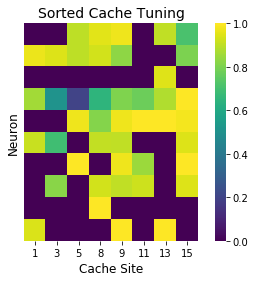


ExtractedWithXY_Cleaned184430_09102019.mat
[ 1  4  6  7 10 12 14 17 20 24 25 27 28 29 30 31]
Min: 0.32
Max: 1.00
[ 1.  1.  5.  5.  7. 10. 10. 11. 13. 15. 15. 16. 16.]


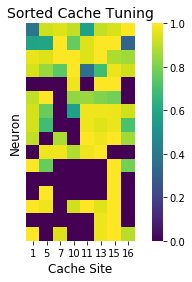


ExtractedWithXY_Cleaned184526_09102019.mat
[ 7 15 17 25 28 31 34 38 39 42 43]
Min: 0.67
Max: 1.00
[ 1.  1.  3.  3.  7.  7.  8.  8. 10. 10. 15. 15.]


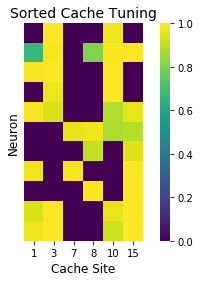


ExtractedWithXY_Cleaned184946_09102019.mat
[ 3  5  6 10 15 17 18 28 29 30 31 46 50]
Min: 0.33
Max: 1.00
[ 1.  1.  4.  5.  5.  6.  6.  7.  7.  7.  8. 10. 10. 10. 12. 12. 14. 14.
 14. 14.]


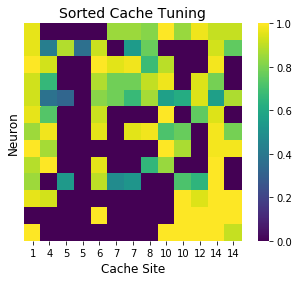


ExtractedWithXY_Cleaned185033_09102019.mat
[ 3 19 20 21 24 29 31 35 39 46]
Min: 0.39
Max: 1.00
[ 2.  2.  5.  5.  7.  9. 11. 11. 14. 16. 16.]


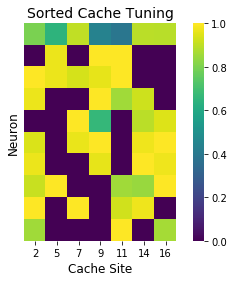


ExtractedWithXY_Cleaned184331_09102019.mat
[ 3 14 23 39 40 43]
Min: 0.62
Max: 1.00
[ 1.  1.  3.  3.  6.  6. 10. 10. 10. 10.]


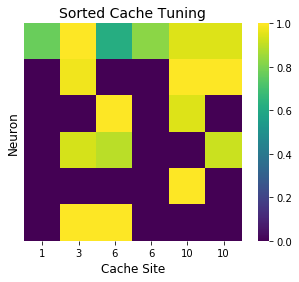


ExtractedWithXY_Cleaned144233_09112019.mat
[ 7  8  9 19 22 24 30 31 36 45]
Min: 0.42
Max: 1.00
[ 1.  1.  1.  1.  3.  3.  5.  5.  5.  5.  5.  5.  7.  7. 10. 10. 12. 12.
 14. 14. 14. 14.]


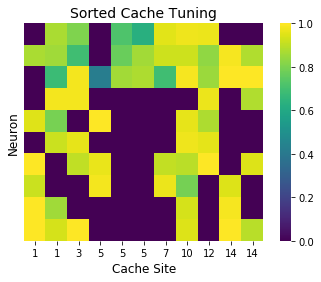


Total Num: 76


In [25]:
ep_f = "mi-hopvis-circvisshuff-60.p"
ep_f = "ci-visit-shuff-60.p"
with open(ep_f, "rb") as f:
    results = pickle.load(f)
total = 0
for key1 in results.keys():
    cache_idx_mat = results[key1]
    f = h5py.File("data/" + key1, 'r')
    f = DataFile(f)
    neurs = np.argwhere(np.nansum(cache_idx_mat, axis=0)>0).squeeze()
    cache_idx_mat = cache_idx_mat[f.was_cache,:]
    cache_only_sites = f.cache_sites[f.was_cache]
    cache_idx_mat = cache_idx_mat[np.argsort(cache_only_sites),:]
    print(key1)
    print(neurs)
    print("Min: %1.2f"%cache_idx_mat[cache_idx_mat > 0].min())
    print("Max: %1.2f"%np.nanmax(cache_idx_mat))
    print(np.sort(f.cache_sites))
    ax = sns.heatmap(cache_idx_mat[:,neurs].T, cmap="viridis")
    ax.set_aspect("equal")
    plt.xlabel("Cache Site", fontsize=12)
    plt.ylabel("Neuron", fontsize=12)
    plt.xticks(np.arange(cache_only_sites.size)+0.5, np.sort(cache_only_sites.astype(int)))
    plt.yticks([])
    plt.title("Sorted Cache Tuning", fontsize=14)
    plt.show()
    print()
    total += neurs.size
print("Total Num: %d"%total)

## Calculating cache index matrix visit-by-visit

In [7]:
results = {}
for mat_file in mat_files:
    print(mat_file)
    f = h5py.File("data/" + mat_file, 'r')
    f = DataFile(f)
    cache_idxs = np.zeros((f.cache_sites.size, f.num_neurs))
    for idx in range(f.cache_sites.size):
        cache_site = f.cache_sites[idx]
        cache_frames = np.arange(f.cache_enters[idx], f.cache_exits[idx]).astype(int)
        noncache_enters = f.noncache_enters[f.noncache_wedges == cache_site]
        noncache_exits = f.noncache_exits[f.noncache_wedges == cache_site]
        noncache_frames = [
            np.arange(enter, exit).astype(int) for \
            enter, exit in zip(noncache_enters, noncache_exits)
            ]
        cache_idx = calc_cache_index(f.fr, cache_frames, noncache_frames)
        significant = np.zeros(cache_idx.size)
        for _ in range(110):
            shuff_cache_frames, shuff_noncache_frames = shuffle_1darray_lists(
                cache_frames, noncache_frames
                )
            shuff_cache_idx = calc_cache_index(
                f.fr, shuff_cache_frames, shuff_noncache_frames
                )
            significant += (cache_idx > shuff_cache_idx)
        significant = significant > 0.99*110
        cache_idxs[idx,significant] = cache_idx[significant]
    results[mat_file] = cache_idxs
# with open("ci-visit-shuff-%d.p"%window, "wb") as f:
#     pickle.dump(results,f)

ExtractedWithXY_Cleaned184713_09102019.mat
ExtractedWithXY_Cleaned184430_09102019.mat
ExtractedWithXY_Cleaned184526_09102019.mat
ExtractedWithXY_Cleaned184946_09102019.mat
ExtractedWithXY_Cleaned185033_09102019.mat
ExtractedWithXY_Cleaned184331_09102019.mat
ExtractedWithXY_Cleaned144233_09112019.mat


ExtractedWithXY_Cleaned184713_09102019.mat
[ 1  2  4  5  6  7  9 11 12 14 15 17 18 20 21 22 23 25 26 27 29 32 34 35
 38 40 41]
Min: 0.79
Max: 1.00


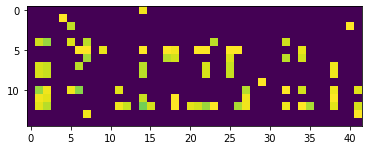


ExtractedWithXY_Cleaned184430_09102019.mat
[ 1  2  6  7 12 13 14 17 20 21 22 23 25 29 30 31 32 33 34 36 38 39 41 42
 43 44 46]
Min: 0.79
Max: 1.00


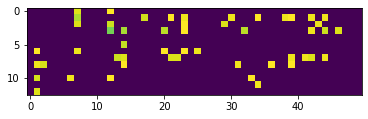


ExtractedWithXY_Cleaned184526_09102019.mat
[ 2  3  4  5  6  7  8 11 12 13 14 15 17 18 20 21 23 26 29 30 31 33 35 38
 39 42 43]
Min: 0.81
Max: 1.00


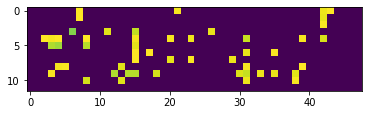


ExtractedWithXY_Cleaned184946_09102019.mat
[ 1  2  3  5  6  7  8  9 10 12 14 15 17 18 19 21 22 25 26 27 28 29 30 31
 32 33 34 35 36 38 41 42 43 44 45 46 47 48 49 50 52 53 54 55 56 57 58 59
 60 61]
Min: 0.79
Max: 1.00


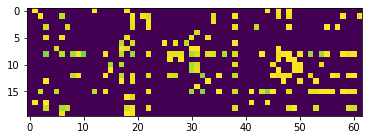


ExtractedWithXY_Cleaned185033_09102019.mat
[ 0  2  4  5  7  8 10 11 15 18 19 20 22 24 25 26 27 29 31 32 33 34 35 39
 40 42 45 46 47 48 49 50]
Min: 0.87
Max: 1.00


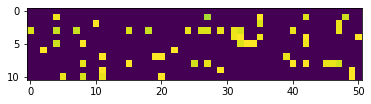


ExtractedWithXY_Cleaned184331_09102019.mat
[ 1  3  4  6 12 15 16 17 18 19 21 23 32 34 36 38 40 43]
Min: 0.82
Max: 1.00


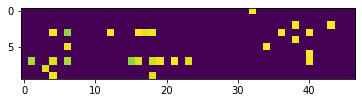


ExtractedWithXY_Cleaned144233_09112019.mat
[ 1  3  5  7  8  9 11 12 13 14 16 18 19 20 21 22 23 24 25 29 30 31 32 33
 34 36 38 39 43 44 45 46 48 49 51 53]
Min: 0.83
Max: 1.00


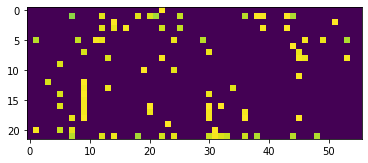


Total Num: 217


In [8]:
total = 0
for key1 in results.keys():
    cache_idx_mat = results[key1]
    neurs = np.argwhere(np.sum(cache_idx_mat, axis=0)>0).squeeze()
    print(key1)
    print(neurs)
    print("Min: %1.2f"%cache_idx_mat[cache_idx_mat > 0].min())
    print("Max: %1.2f"%cache_idx_mat.max())
    plt.imshow(cache_idx_mat); plt.show()
    print()
    total += neurs.size
print("Total Num: %d"%total)

## Calculating cache index matrix with agglomerated visits

In [7]:
window = 30
results = {}
for mat_file in mat_files:
    print(mat_file)
    f = h5py.File("data/" + mat_file, 'r')
    wedges = np.array(f['whichWedge']).squeeze()
    cache_sites = np.array(f['CacheSites']).squeeze()
    pokes = np.array(f['CacheFrames']).squeeze().astype(int) - 1
    enters = np.array(f['CacheFramesEnter']).squeeze().astype(int) - 1
    exits = np.array(f['CacheFramesExit']).squeeze().astype(int) - 1
    was_retrieval = np.array(f['ThisWasRetrieval']).squeeze().astype(bool)
    spikes = np.array(f['S'])
    fr = get_fr(spikes)
    cache_idxs = np.zeros((np.unique(cache_sites).size, fr.shape[1]))
    all_cache_frames, all_noncache_frames = get_cache_index_frames(
        wedges, cache_sites, pokes, enters, exits,
        fr, window
        )    
    for idx, cache_site in enumerate(np.unique(cache_sites)):
        cache_frames, _ = get_poke_centered_frames(
            window, wedges,
            cache_site, cache_sites,
            pokes, enters, exits
            )
        noncache_frames = all_noncache_frames[cache_site]
        cache_idx = calc_cache_index(fr, cache_frames, noncache_frames)
        significant = np.zeros(cache_idx.size)
        for _ in range(110):
            shuff_cache_frames, shuff_noncache_frames = shuffle_1darray_lists(
                cache_frames, noncache_frames
                )
            shuff_cache_idx = calc_cache_index(
                fr, shuff_cache_frames, shuff_noncache_frames
                )
            significant += (cache_idx > shuff_cache_idx)
        significant = significant > 0.99*110
        cache_idxs[idx,significant] = cache_idx[significant]        
    results[mat_file] = cache_idxs
with open("ci-agglom-shuff-%d.p"%window, "wb") as f:
    pickle.dump(results,f)

ExtractedWithXY_Cleaned184713_09102019.mat
ExtractedWithXY_Cleaned184430_09102019.mat
ExtractedWithXY_Cleaned184526_09102019.mat
ExtractedWithXY_Cleaned184946_09102019.mat
ExtractedWithXY_Cleaned185033_09102019.mat
ExtractedWithXY_Cleaned184331_09102019.mat
ExtractedWithXY_Cleaned144233_09112019.mat


ExtractedWithXY_Cleaned184713_09102019.mat
[ 1  2  6  7  9 14 17 18 21 22 25 29 34 38 41]


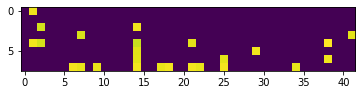


ExtractedWithXY_Cleaned184430_09102019.mat
[ 1  6  7  8 12 13 14 23 24 27 30 31 33 36 39]


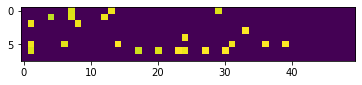


ExtractedWithXY_Cleaned184526_09102019.mat
[ 3  4  5  7  8 13 15 17 20 21 23 31 35 38 39 42 43]


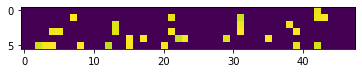


ExtractedWithXY_Cleaned184946_09102019.mat
[ 1  3  5  6 17 18 19 21 22 26 27 28 30 31 33 35 36 37 38 40 41 44 46 47
 48 49 50 52 53 56]


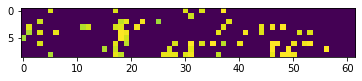


ExtractedWithXY_Cleaned185033_09102019.mat
[ 2  8 10 11 18 19 20 21 27 28 32 35 42 46 47 49 50]


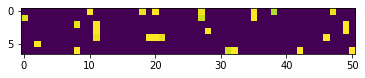


ExtractedWithXY_Cleaned184331_09102019.mat
[ 6 14 18 32 34 36 37 38 40]


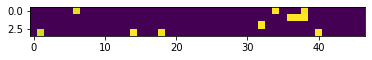


ExtractedWithXY_Cleaned144233_09112019.mat
[ 7  9 11 12 13 14 19 20 22 23 30 31 32 33 36 45 46 49 53]


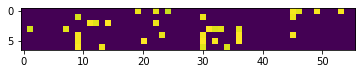


Total Num: 122


In [9]:
total = 0
for key1 in results.keys():
    cache_idx_mat = results[key1]
    neurs = np.argwhere(np.sum(cache_idx_mat, axis=0)>0.95).squeeze()
    print(key1)
    print(neurs)
#     print("Min: %1.2f"%cache_idx_mat[cache_idx_mat > 0].min())
#     print("Max: %1.2f"%cache_idx_mat.max())
    plt.imshow(cache_idx_mat); plt.show()
    print()
    total += neurs.size
print("Total Num: %d"%total)

In [13]:
f = h5py.File("data/" + mat_files[-2], 'r')
f = DataFile(f)

In [14]:
f.cache_sites

array([ 6.,  6.,  3.,  3.,  1.,  1., 10., 10., 10., 10.])

In [16]:
((1/16)*2*pi)*180/pi

22.5

In [17]:
((3/16)*2*pi)*180/pi

67.5

In [18]:
((6/16)*2*pi)*180/pi

135.0

In [19]:
((10/16)*2*pi)*180/pi

225.0